# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [66]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


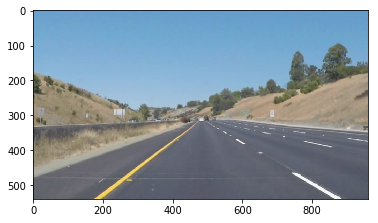

In [67]:
#reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [121]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    sum_right_line = 0
    sum_left_line = 0
    num_right_line = 0
    num_left_line = 0
    avg_right_line = 0
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    
    right_array = []
    del_right_array = []
    left_array = []
    del_left_array = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            #drawing all lines out
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            #define acceptable slope range
            middle_num = 0.65 
            range_for_middle_num = 0.25
            
            #I try to get the slope value
            slope = ((y2-y1)/(x2-x1))
            #then seperate the left/right ones and abandon horizontal lines or over tilt lines
            if slope > 0 and x1 > 500 and x2 > 500 : #possible right lines
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num :
                    #print('right slope is ',((y2-y1)/(x2-x1)))
                    sum_right_line += slope
                    num_right_line += 1
                    right_array.append([x1,y1])
                    right_array.append([x2,y2])
                    sum_right_xposition += (x1 + x2)
                    sum_right_yposition += (y1 + y2)
                    
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 10)
                    
            elif slope < 0: #possible left lines
                
                if  middle_num-range_for_middle_num < abs(slope) < middle_num+range_for_middle_num and x1 < 450 and x2 < 450:
                    #print('left slope is ',((y2-y1)/(x2-x1)))
                    #print('slope=',slope)
                    sum_left_line += slope
                    num_left_line += 1
                    left_array.append([x1,y1])
                    left_array.append([x2,y2])
                    sum_left_xposition += (x1 + x2)
                    sum_left_yposition += (y1 + y2)
                    #cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 10)
                   
    
    #print('slope is ',((y2-y1)/(x2-x1)))
            
    #average slope calculation
    avg_slope_right = sum_right_line/num_right_line
    avg_slope_left = sum_left_line/num_left_line
    avg_right_xposition = sum_right_xposition/(num_right_line*2)
    avg_right_yposition = sum_right_yposition/(num_right_line*2)
    avg_left_xposition = sum_left_xposition / (num_left_line*2)
    avg_left_yposition = sum_left_yposition / (num_left_line*2)
    
    
    
    #print('avg right position is x=',avg_right_xposition,' y= ',avg_right_yposition )
    #print('avg right slope is x=',avg_slope_right,' avg left slope= ',avg_slope_left )
    
    right_array.sort(reverse=True)
    left_array.sort(reverse=True)
    # for further delete some irrelevant points 
    for i in range(len(right_array)):
        #print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (abs(right_array[i][0]-avg_right_xposition) > 250) or (abs(right_array[i][1]-avg_right_yposition) > 120): 
            del_right_array.append(i)

    for i in range(len(left_array)):
        #print('i is ',i,' left array i0 is ',left_array[i][0],'i1 is ', left_array[i][1])
        if (abs(left_array[i][0]-avg_left_xposition) > 250) or (abs(left_array[i][1]-avg_left_yposition) < -120): 
            del_left_array.append(i)
    
    # for deleting some point are not in the decendant order
    for i in range(0,len(right_array)-2,1):
        #print ('new i is ', i,'i0= ',right_array[i][0],' i+1 0=',right_array[i+1][0],' i+2 0=',right_array[i+2][0] )
        if (right_array[i][1]-right_array[i+1][1]<-3) and (right_array[i][1]-right_array[i+2][1]<-3):
            del_right_array.append(i+1)
            del_right_array.append(i+2)
    for i in range(0,len(left_array)-2,1):
        #print ('new i is ', i,'i0= ',left_array[i][0],' i+1 0=',left_array[i+1][0],' i+2 0=',left_array[i+2][0] )
        if (left_array[i][1]-left_array[i+1][1]>3) and (left_array[i][1]-left_array[i+2][1]>3):
            del_left_array.append(i+1)
            del_left_array.append(i+2)        
    
    
    
    
        
    #print('del array is ', del_right_array)
    # re-arrange array
    new_del_right_array = sorted(set(del_right_array))
    new_del_left_array = sorted(set(del_left_array))
    #print('del array is ', new_del_right_array)
    del_right_array.sort()
    del_left_array.sort()
    for v in reversed(new_del_right_array):
        #print('v is ', v)
        del right_array[v]
    for v in reversed(new_del_left_array):
        #print('v is ', v)
        del left_array[v]
    
    #print('avg right slope is ',avg_slope_right)
    #print('avg left slope is ',avg_slope_left)
    #print('right array is ', right_array)
    right_x1_position = int(round((right_array[0][0]+right_array[1][0])/2))
    last_index_left_array = len(left_array)-1
    left_x1_position = int(round((left_array[last_index_left_array][0]+left_array[last_index_left_array-2][0])/2))
    #min_line_x_position = (right_x1_position + left_x1_position)/2
    min_line_x_position = 480
    #print('min line is ', min_line_x_position)
    
    
    del_right_array = []
    del_left_array=[]
    for i in range(len(right_array)):
        #print('i is ',i,' right array i0 is ',right_array[i][0],'i1 is ', right_array[i][1])
        if (right_array[i][0] < min_line_x_position): 
            del_right_array.append(i)
            
    for i in range(len(left_array)):
        if(left_array[i][0] > min_line_x_position):
            del_left_array.append(i)
            
    # re-arrange array
    new_del_right_array = sorted(set(del_right_array))
    new_del_left_array = sorted(set(del_left_array))
    #print('del array is ', new_del_right_array)
    del_right_array.sort()
    del_left_array.sort()
    for v in reversed(new_del_right_array):
        #print('Rv is ', v)
        del right_array[v]
    for v in reversed(new_del_left_array):
        #print('Lv is ', v)
        del left_array[v]
    
    
    # calculate again the avg x y position for drawing final line
    sum_right_xposition = 0
    sum_right_yposition = 0
    sum_left_xposition = 0
    sum_left_yposition = 0
    for i in range(len(right_array)):
        sum_right_xposition += right_array[i][0]
        sum_right_yposition += right_array[i][1]
        
    for i in range(len(left_array)):
        sum_left_xposition += left_array[i][0]
        sum_left_yposition += left_array[i][1]
            
    avg_right_xposition = sum_right_xposition/(len(right_array))
    avg_right_yposition = sum_right_yposition/(len(right_array))
    avg_left_xposition = sum_left_xposition/(len(left_array))
    avg_left_yposition = sum_left_yposition/(len(left_array))
    #print('avg right x position= ',avg_right_xposition)
    #print('avg right y position= ',avg_right_yposition)
    
    last_index_right_array = len(right_array)-1
    last_index_left_array = len(left_array)-1
    
    #calculate  points for slope
    final_x1_right=right_x1_position
    final_y1_right=right_array[0][1]
    final_y2_right=int(round(avg_right_yposition))
    final_x2_right=int(round(avg_right_xposition))
    
    final_x1_left=left_x1_position
    final_y1_left=left_array[last_index_left_array][1]
    final_y2_left=int(round(avg_left_yposition))
    final_x2_left=int(round(avg_left_xposition))
    
    #calculate left/right slope and avoid some denominator or numerator is 0
    if(final_x2_right==final_x1_right):
        final_x2_right = final_x2_right+1
    else:
        final_x2_right = final_x2_right
        
    if(final_y2_right==final_y1_right):
        slope_right=avg_slope_right
    else:
        slope_right = (final_y2_right-final_y1_right)/(final_x2_right-final_x1_right)
    #print('slope right = ',slope_right)
    
    if(final_x2_left==final_x1_left):
        final_x2_left = final_x2_left+1
    else:
        final_x2_left = final_x2_left
        
    if(final_y2_left==final_y1_left):
        slope_left=avg_slope_left
    else:
        slope_left = (final_y2_left-final_y1_left)/(final_x2_left-final_x1_left)
    
    
    #calculate final extrapolated points for drawing
    if (final_y1_right - imshape[0])< -30:
        final_x1_right = int(round((imshape[0]-final_y1_right)/slope_right+final_x1_right))
        final_y1_right = imshape[0]
        
    if (final_y2_right - 320) > 30:
        #print('final_y2=',final_y2,'slope_right=',slope_right,'final_x2=',final_x2)
        final_x2_right = int(round(340-final_y2_right)/slope_right+final_x2_right)
        final_y2_right = 340
    
    if (final_y1_left - imshape[0])< -30:
        final_x1_left = int(round((imshape[0]-final_y1_left)/slope_left+final_x1_left))
        final_y1_left = imshape[0]
        
    if (final_y2_left - 320) > 30:
        #print('final_y2=',final_y2,'slope_right=',slope_right,'final_x2=',final_x2)
        final_x2_left = int(round(340-final_y2_left)/slope_left+final_x2_left)
        final_y2_left = 340
    
    
    #print('final x2=', final_x2,' final y2=', final_y2)
    cv2.line(img,(final_x1_right,final_y1_right),(final_x2_right,final_y2_right),[0,255,0],15) 
    cv2.line(img,(final_x1_left,final_y1_left),(final_x2_left,final_y2_left),[0,255,0],15)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

files are ['solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']
v  solidYellowCurve.jpg
v  solidYellowCurve2.jpg
v  solidWhiteRight.jpg
v  solidYellowLeft.jpg
v  whiteCarLaneSwitch.jpg
v  solidWhiteCurve.jpg


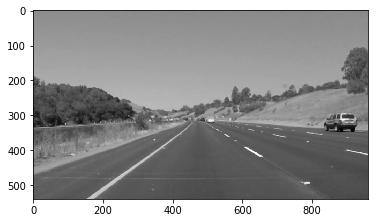

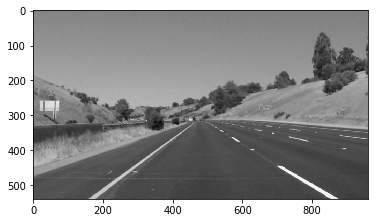

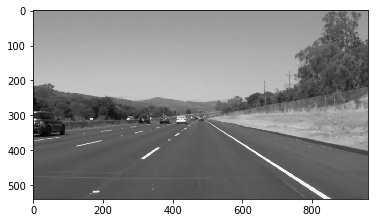

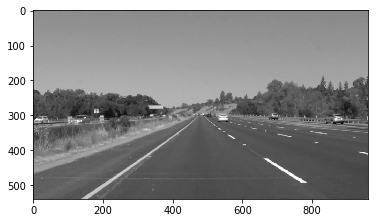

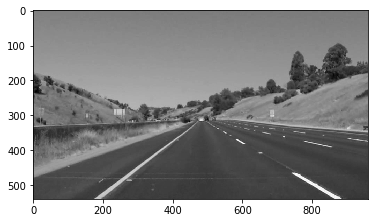

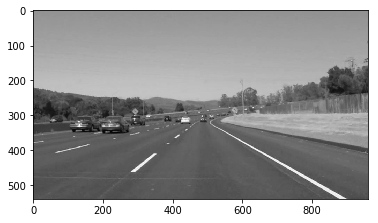

In [122]:
import os
files=os.listdir("test_images/")
print('files are',files)
gray_list=[]
image_list=[]
for v in files:
    print('v ',v)
    image = mpimg.imread('test_images/'+v)
    image_list.append(image)
    gray = grayscale(image)
    plt.figure()
    plt.imshow(gray, cmap='gray')
    gray_list.append(gray)



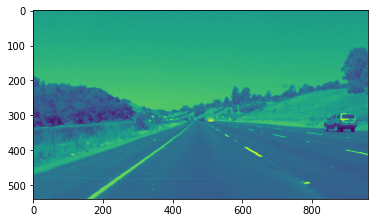

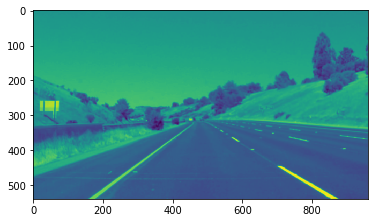

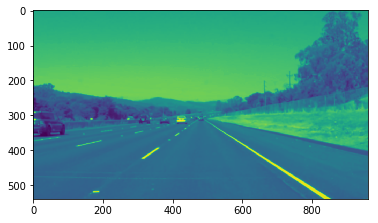

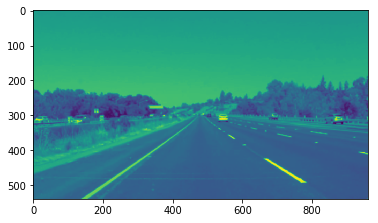

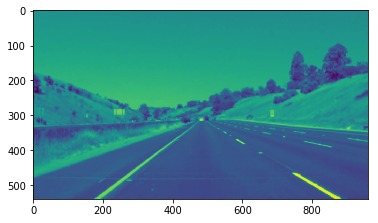

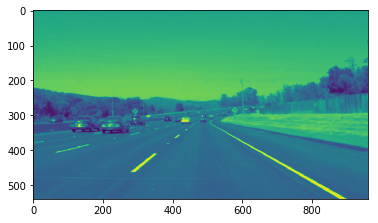

In [123]:
blur_gray_list=[]
for v in gray_list:
    blur_gray=gaussian_blur(v,5)
    plt.figure()
    plt.imshow(blur_gray)
    blur_gray_list.append(blur_gray)


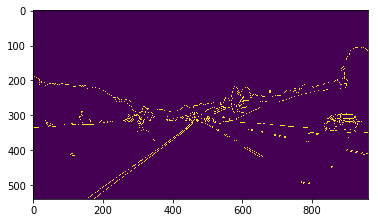

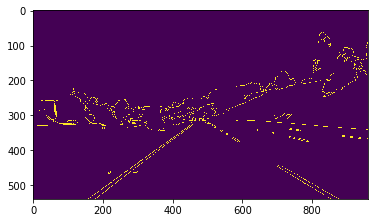

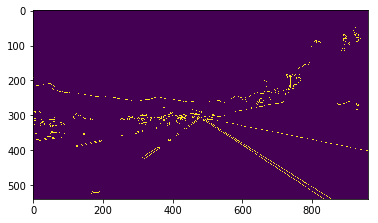

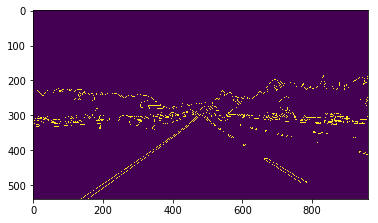

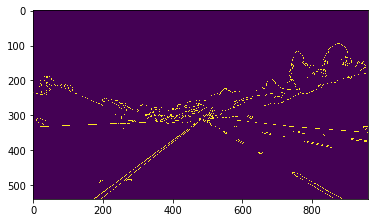

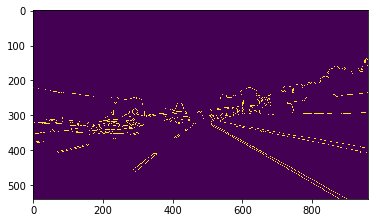

In [124]:
edges_list=[]
for v in blur_gray_list:
    edges = canny(v,10,180)
    plt.figure()
    plt.imshow(edges)
    edges_list.append(edges)



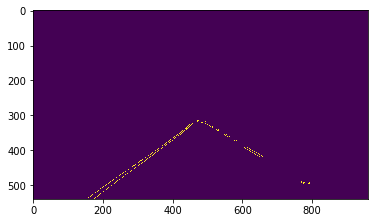

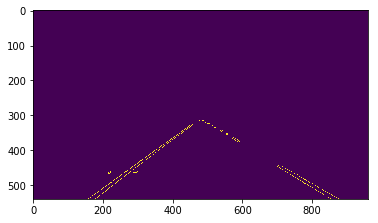

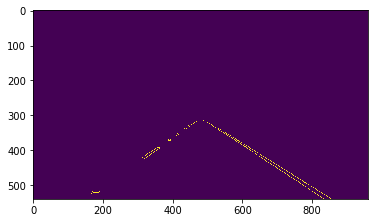

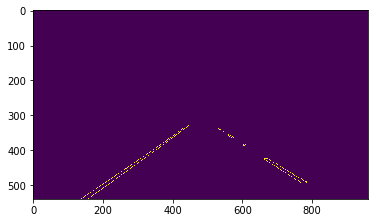

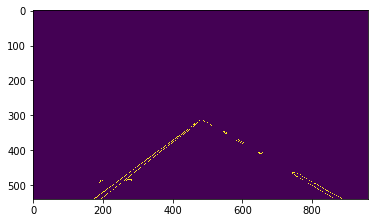

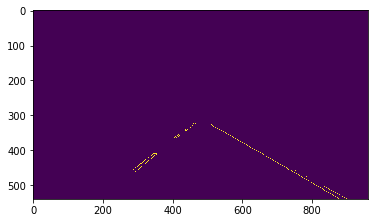

In [125]:
# This time we are defining a four sided polygon to mask
i=0
masked_edges_list=[]
for v in image_list:
    #print('i is ',i,'len of edges list is ', len(edges_list))
    imshape = v.shape
    vertices = np.array([[(60,imshape[0]),(470, 315), (490, 315), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges_list[i],vertices)
    plt.figure()
    plt.imshow(masked_edges)
    i=i+1
    masked_edges_list.append(masked_edges)



slope= -0.702380952381
slope= -0.73125
slope= -0.714285714286
slope= -0.8
slope= -0.727272727273
slope= -0.875
slope= -0.846153846154
slope= -0.75
slope= -0.5
slope= -0.711538461538
slope= -0.5
slope= -0.666666666667
slope= -0.725490196078
slope= -0.6
slope= -0.75
slope= -0.75
slope= -0.625
slope= -0.8
slope= -0.722727272727
slope= -0.8
slope= -0.795454545455
slope= -0.857142857143
slope= -0.729166666667
slope= -0.770833333333
slope= -0.8
slope= -0.740740740741
slope= -0.833333333333
slope= -0.85
slope= -0.85
slope= -0.724137931034
slope= -0.666666666667
slope= -0.725190839695
slope= -0.727272727273
slope= -0.714285714286
slope= -0.692307692308
slope= -0.705882352941
slope= -0.75
slope= -0.5
slope= -0.733333333333
slope= -0.666666666667
slope= -0.726744186047
slope= -0.8
slope= -0.647058823529
slope= -0.63829787234
slope= -0.545454545455
slope= -0.714285714286
slope= -0.64
slope= -0.6
slope= -0.5
slope= -0.647058823529
slope= -0.647058823529
slope= -0.5
slope= -0.5
slope= -0.5
slope= -

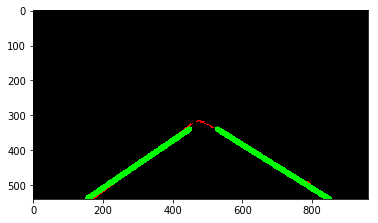

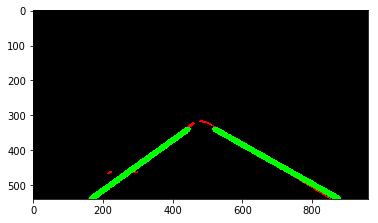

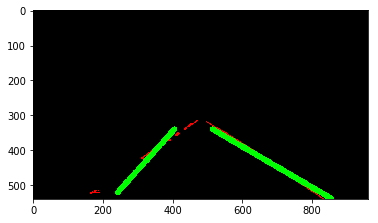

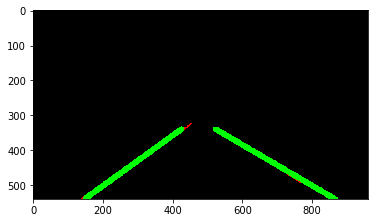

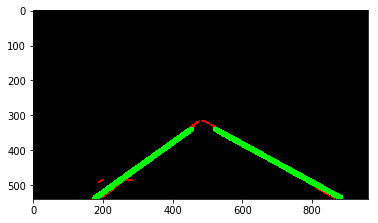

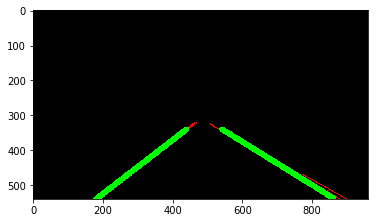

In [126]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 3
max_line_gap = 7
lines_list=[]
for v in masked_edges_list:
    lines=hough_lines(v,rho,theta,threshold,min_line_length,max_line_gap)
    plt.figure()
    plt.imshow(lines)
    lines_list.append(lines)


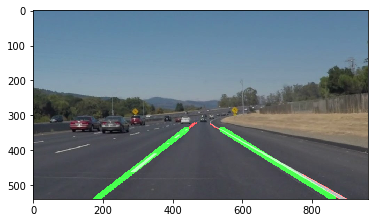

In [127]:
mix = weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.imshow(mix)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [128]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [129]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [130]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray = grayscale(image)
    blur_gray = gaussian_blur(gray, 5)
    edges = canny(blur_gray, 10, 180)
    imshape = image.shape
    vertices = np.array([[(60,imshape[0]),(470, 315), (490, 315), (imshape[1]-60,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 3
    max_line_gap = 7
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [131]:
white_output = 'SYL_segment_lines_solidYellowLeft_avg_slope_fix_minus_bug.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

slope= -0.571428571429
slope= -0.692307692308
slope= -0.6875
slope= -0.625
slope= -0.688888888889
slope= -0.666666666667
slope= -0.642857142857
slope= -0.75
slope= -0.6875
slope= -0.777777777778
slope= -0.666666666667
slope= -0.666666666667
slope= -0.75
slope= -0.75
slope= -0.625
slope= -0.684210526316
slope= -0.5
slope= -0.6
slope= -0.6875
slope= -0.5
slope= -0.75
slope= -0.666666666667
slope= -0.642857142857
slope= -0.692307692308
slope= -0.666666666667
[MoviePy] >>>> Building video SYL_segment_lines_solidWhiteRight_avg_slope_fix_minus_bug.mp4
[MoviePy] Writing video SYL_segment_lines_solidWhiteRight_avg_slope_fix_minus_bug.mp4


  3%|▎         | 7/222 [00:00<00:03, 67.16it/s]

slope= -0.571428571429
slope= -0.692307692308
slope= -0.6875
slope= -0.625
slope= -0.688888888889
slope= -0.666666666667
slope= -0.642857142857
slope= -0.75
slope= -0.6875
slope= -0.777777777778
slope= -0.666666666667
slope= -0.666666666667
slope= -0.75
slope= -0.75
slope= -0.625
slope= -0.684210526316
slope= -0.5
slope= -0.6
slope= -0.6875
slope= -0.5
slope= -0.75
slope= -0.666666666667
slope= -0.642857142857
slope= -0.692307692308
slope= -0.666666666667
slope= -0.756302521008
slope= -0.701754385965
slope= -0.703703703704
slope= -0.6
slope= -0.705882352941
slope= -0.702127659574
slope= -0.846153846154
slope= -0.75
slope= -0.733333333333
slope= -0.727272727273
slope= -0.75
slope= -0.777777777778
slope= -0.888888888889
slope= -0.636363636364
slope= -0.745098039216
slope= -0.727272727273
slope= -0.705882352941
slope= -0.776119402985
slope= -0.724637681159
slope= -0.625
slope= -0.857142857143
slope= -0.733333333333
slope= -0.808510638298
slope= -0.666666666667
slope= -0.75
slope= -0.8
slo

 11%|█         | 24/222 [00:00<00:02, 72.97it/s]

slope= -0.666666666667
slope= -0.722222222222
slope= -0.707317073171
slope= -0.739130434783
slope= -0.833333333333
slope= -0.707692307692
slope= -0.74358974359
slope= -0.666666666667
slope= -0.666666666667
slope= -0.428571428571
slope= -0.8
slope= -0.777777777778
slope= -0.758620689655
slope= -0.6
slope= -0.666666666667
slope= -0.5
slope= -0.692307692308
slope= -0.5
slope= -0.857142857143
slope= -0.692307692308
slope= -0.6875
slope= -0.875
slope= -0.666666666667
slope= -0.666666666667
slope= -0.666666666667
slope= -0.8
slope= -0.666666666667
slope= -0.75
slope= -0.875
slope= -0.5
slope= -0.6
slope= -0.666666666667
slope= -0.857142857143
slope= -0.75
slope= -0.818181818182
slope= -0.85
slope= -0.75
slope= -0.666666666667
slope= -0.666666666667
slope= -0.833333333333
slope= -0.727272727273
slope= -0.75
slope= -0.8
slope= -0.666666666667
slope= -0.666666666667
slope= -0.428571428571
slope= -0.625
slope= -0.8
slope= -0.666666666667
slope= -0.666666666667
slope= -0.714285714286
slope= -0.7


 18%|█▊        | 40/222 [00:00<00:02, 75.83it/s]

slope= -0.684210526316
slope= -0.8
slope= -0.620689655172
slope= -0.777777777778
slope= -0.666666666667
slope= -0.6
slope= -0.857142857143
slope= -0.615384615385
slope= -0.888888888889
slope= -0.75
slope= -0.608695652174
slope= -0.666666666667
slope= -0.8
slope= -0.8
slope= -0.666666666667
slope= -0.711111111111
slope= -0.714285714286
slope= -0.677419354839
slope= -0.666666666667
slope= -0.758620689655
slope= -0.6
slope= -0.75
slope= -0.555555555556
slope= -0.5
slope= -0.714285714286
slope= -0.7
slope= -0.714285714286
slope= -0.857142857143
slope= -0.571428571429
slope= -0.625
slope= -0.75
slope= -0.555555555556
slope= -0.5
slope= -0.636363636364
slope= -0.571428571429
slope= -0.6
slope= -0.625
slope= -0.666666666667
slope= -0.75
slope= -0.5
slope= -0.660714285714
slope= -0.676470588235
slope= -0.75
slope= -0.708333333333
slope= -0.666666666667
slope= -0.666666666667
slope= -0.5
slope= -0.818181818182
slope= -0.857142857143
slope= -0.666666666667
slope= -0.685714285714
slope= -0.428571

 24%|██▍       | 54/222 [00:00<00:02, 67.49it/s]

slope= -0.666666666667
slope= -0.757575757576
slope= -0.8
slope= -0.711538461538
slope= -0.730769230769
slope= -0.846153846154
slope= -0.75
slope= -0.666666666667
slope= -0.818181818182
slope= -0.6
slope= -0.666666666667
slope= -0.833333333333
slope= -0.75
slope= -0.571428571429
slope= -0.666666666667
slope= -0.666666666667
slope= -0.636363636364
slope= -0.666666666667
slope= -0.753246753247
slope= -0.685185185185
slope= -0.676470588235
slope= -0.7
slope= -0.666666666667
slope= -0.6
slope= -0.75641025641
slope= -0.571428571429
slope= -0.6
slope= -0.684210526316
slope= -0.6
slope= -0.833333333333
slope= -0.752475247525
slope= -0.720930232558
slope= -0.666666666667
slope= -0.818181818182
slope= -0.755555555556
slope= -0.730769230769
slope= -0.789473684211
slope= -0.846153846154
slope= -0.745098039216
slope= -0.8
slope= -0.75
slope= -0.742857142857
slope= -0.571428571429
slope= -0.666666666667
slope= -0.777777777778
slope= -0.777777777778
slope= -0.75
slope= -0.7265625
slope= -0.697183098

 31%|███       | 68/222 [00:00<00:02, 62.45it/s]

slope= -0.615384615385
slope= -0.655737704918
slope= -0.5
slope= -0.692307692308
slope= -0.6
slope= -0.636363636364
slope= -0.5
slope= -0.6
slope= -0.65
slope= -0.583333333333
slope= -0.709090909091
slope= -0.571428571429
slope= -0.705882352941
slope= -0.571428571429
slope= -0.6875
slope= -0.7
slope= -0.5
slope= -0.666666666667
slope= -0.666666666667
slope= -0.625
slope= -0.666666666667
slope= -0.707317073171
slope= -0.692307692308
slope= -0.670454545455
slope= -0.75
slope= -0.470588235294
slope= -0.5
slope= -0.666666666667
slope= -0.690476190476
slope= -0.6
slope= -0.666666666667
slope= -0.5
slope= -0.692307692308
slope= -0.714285714286
slope= -0.636363636364
slope= -0.615384615385
slope= -0.666666666667
slope= -0.666666666667
slope= -0.707317073171
slope= -0.6
slope= -0.672566371681
slope= -0.682926829268
slope= -0.666666666667
slope= -0.8
slope= -0.688524590164
slope= -0.75
slope= -0.5625
slope= -0.588235294118
slope= -0.833333333333
slope= -0.666666666667
slope= -0.685185185185
slo

 34%|███▍      | 75/222 [00:01<00:02, 60.42it/s]

 -0.5
slope= -0.666666666667
slope= -0.666666666667
slope= -0.833333333333
slope= -0.725806451613
slope= -0.615384615385
slope= -0.666666666667
slope= -0.733333333333
slope= -0.6
slope= -0.615384615385
slope= -0.6
slope= -0.588235294118
slope= -0.8
slope= -0.571428571429
slope= -0.6
slope= -0.75
slope= -0.7
slope= -0.777777777778
slope= -0.75
slope= -0.75
slope= -0.666666666667
slope= -0.588235294118
slope= -0.75
slope= -0.5
slope= -0.571428571429
slope= -0.666666666667
slope= -0.8
slope= -0.650602409639
slope= -0.666666666667
slope= -0.736842105263
slope= -0.642857142857
slope= -0.642857142857
slope= -0.75
slope= -0.785714285714
slope= -0.75
slope= -0.666666666667
slope= -0.785714285714
slope= -0.857142857143
slope= -0.733333333333
slope= -0.666666666667
slope= -0.6
slope= -0.6
slope= -0.785714285714
slope= -0.8
slope= -0.625
slope= -0.666666666667
slope= -0.651162790698
slope= -0.666666666667
slope= -0.636363636364
slope= -0.5
slope= -0.654545454545
slope= -0.625
slope= -0.6470588235

 36%|███▋      | 81/222 [00:01<00:02, 58.79it/s]

slope= -0.612244897959
slope= -0.666666666667
slope= -0.6
slope= -0.666666666667
slope= -0.620689655172
slope= -0.714285714286
slope= -0.666666666667
slope= -0.714285714286
slope= -0.6
slope= -0.555555555556
slope= -0.631578947368
slope= -0.666666666667
slope= -0.6
slope= -0.666666666667
slope= -0.5


 39%|███▉      | 87/222 [00:01<00:02, 57.71it/s]

slope= -0.610169491525
slope= -0.7
slope= -0.666666666667
slope= -0.625
slope= -0.833333333333
slope= -0.7
slope= -0.666666666667
slope= -0.666666666667
slope= -0.625
slope= -0.714285714286
slope= -0.676923076923
slope= -0.5
slope= -0.631578947368
slope= -0.619718309859
slope= -0.727272727273
slope= -0.888888888889
slope= -0.75
slope= -0.714285714286
slope= -0.571428571429
slope= -0.666666666667
slope= -0.692307692308
slope= -0.6
slope= -0.5
slope= -0.603773584906
slope= -0.692307692308
slope= -0.5
slope= -0.5625
slope= -0.75
slope= -0.75
slope= -0.75
slope= -0.625
slope= -0.666666666667
slope= -0.5625
slope= -0.5
slope= -0.619047619048
slope= -0.5
slope= -0.5
slope= -0.615384615385
slope= -0.75
slope= -0.857142857143
slope= -0.5625
slope= -0.571428571429
slope= -0.555555555556
slope= -0.666666666667
slope= -0.769230769231
slope= -0.6
slope= -0.626666666667
slope= -0.875
slope= -0.818181818182
slope= -0.626506024096
slope= -0.6
slope= -0.6
slope= -0.818181818182
slope= -0.666666666667


 45%|████▍     | 99/222 [00:01<00:02, 57.48it/s]

slope= -0.636363636364
slope= -0.818181818182
slope= -0.6
slope= -0.583333333333
slope= -0.428571428571
slope= -0.857142857143
slope= -0.6
slope= -0.5
slope= -0.6
slope= -0.764705882353
slope= -0.5
slope= -0.8
slope= -0.636363636364
slope= -0.666666666667
slope= -0.5
slope= -0.583333333333
slope= -0.714285714286
slope= -0.636363636364
slope= -0.583333333333
slope= -0.642857142857
slope= -0.6
slope= -0.6
slope= -0.5
slope= -0.666666666667
slope= -0.769230769231
slope= -0.6
slope= -0.727272727273
slope= -0.75
slope= -0.642857142857
slope= -0.5
slope= -0.8
slope= -0.666666666667
slope= -0.666666666667
slope= -0.769230769231
slope= -0.769230769231
slope= -0.75
slope= -0.5
slope= -0.75
slope= -0.833333333333
slope= -0.5
slope= -0.666666666667
slope= -0.75
slope= -0.621212121212
slope= -0.666666666667
slope= -0.694444444444
slope= -0.6
slope= -0.7
slope= -0.666666666667
slope= -0.666666666667
slope= -0.620689655172
slope= -0.571428571429
slope= -0.666666666667
slope= -0.52380952381
slope= -0

 50%|█████     | 111/222 [00:01<00:01, 55.76it/s]

slope= -0.621621621622
slope= -0.727272727273
slope= -0.648148148148
slope= -0.631578947368
slope= -0.613636363636
slope= -0.75
slope= -0.6
slope= -0.647058823529
slope= -0.818181818182
slope= -0.875
slope= -0.75
slope= -0.875
slope= -0.733333333333
slope= -0.676923076923
slope= -0.75
slope= -0.774193548387
slope= -0.769230769231
slope= -0.666666666667
slope= -0.666666666667
slope= -0.666666666667
slope= -0.75
slope= -0.833333333333
slope= -0.571428571429
slope= -0.75
slope= -0.571428571429
slope= -0.666666666667
slope= -0.666666666667
slope= -0.6
slope= -0.714285714286
slope= -0.666666666667
slope= -0.75
slope= -0.777777777778
slope= -0.6
slope= -0.666666666667
slope= -0.666666666667
slope= -0.650602409639
slope= -0.652173913043
slope= -0.5
slope= -0.714285714286
slope= -0.666666666667
slope= -0.6
slope= -0.611111111111
slope= -0.642857142857
slope= -0.5
slope= -0.666666666667
slope= -0.833333333333
slope= -0.642857142857
slope= -0.631578947368
slope= -0.75
slope= -0.65
slope= -0.6363

 56%|█████▋    | 125/222 [00:01<00:01, 58.48it/s]

slope= -0.642857142857
slope= -0.686274509804
slope= -0.74358974359
slope= -0.5
slope= -0.75
slope= -0.5
slope= -0.5
slope= -0.75
slope= -0.705882352941
slope= -0.757575757576
slope= -0.5
slope= -0.642857142857
slope= -0.545454545455
slope= -0.777777777778
slope= -0.75
slope= -0.733333333333
slope= -0.75
slope= -0.666666666667
slope= -0.6
slope= -0.706896551724
slope= -0.636363636364
slope= -0.666666666667
slope= -0.625
slope= -0.693548387097
slope= -0.8
slope= -0.666666666667
slope= -0.5
slope= -0.5
slope= -0.6
slope= -0.5
slope= -0.625
slope= -0.583333333333
slope= -0.6
slope= -0.75
slope= -0.714285714286
slope= -0.5
slope= -0.666666666667
slope= -0.641025641026
slope= -0.6
slope= -0.657142857143
slope= -0.586206896552
slope= -0.697368421053
slope= -0.833333333333
slope= -0.702702702703
slope= -0.583333333333
slope= -0.75
slope= -0.666666666667
slope= -0.75
slope= -0.571428571429
slope= -0.428571428571
slope= -0.6
slope= -0.666666666667
slope= -0.62962962963
slope= -0.6
slope= -0.833

 63%|██████▎   | 139/222 [00:02<00:01, 58.90it/s]

slope= -0.672131147541
slope= -0.719298245614
slope= -0.666666666667
slope= -0.75
slope= -0.818181818182
slope= -0.68085106383
slope= -0.761904761905
slope= -0.777777777778
slope= -0.666666666667
slope= -0.5
slope= -0.724137931034
slope= -0.72972972973
slope= -0.71186440678
slope= -0.6
slope= -0.711538461538
slope= -0.7
slope= -0.692307692308
slope= -0.6
slope= -0.8
slope= -0.857142857143
slope= -0.7
slope= -0.8
slope= -0.6
slope= -0.714285714286
slope= -0.75
slope= -0.571428571429
slope= -0.693181818182
slope= -0.754385964912
slope= -0.684210526316
slope= -0.710526315789
slope= -0.666666666667
slope= -0.642857142857
slope= -0.782608695652
slope= -0.818181818182
slope= -0.545454545455
slope= -0.5
slope= -0.666666666667
slope= -0.75
slope= -0.666666666667
slope= -0.707317073171
slope= -0.700787401575
slope= -0.72
slope= -0.696078431373
slope= -0.727272727273
slope= -0.6
slope= -0.714285714286
slope= -0.695652173913
slope= -0.75
slope= -0.444444444444
slope= -0.666666666667
slope= -0.833

 68%|██████▊   | 151/222 [00:02<00:01, 58.74it/s]


slope= -0.714285714286
slope= -0.714285714286
slope= -0.666666666667
slope= -0.727272727273
slope= -0.714285714286
slope= -0.694915254237
slope= -0.8125
slope= -0.790697674419
slope= -0.75
slope= -0.75
slope= -0.724137931034
slope= -0.8
slope= -0.75
slope= -0.75
slope= -0.8
slope= -0.857142857143
slope= -0.75
slope= -0.728571428571
slope= -0.666666666667
slope= -0.722222222222
slope= -0.75
slope= -0.75
slope= -0.769230769231
slope= -0.716666666667
slope= -0.725806451613
slope= -0.714285714286
slope= -0.6
slope= -0.736842105263
slope= -0.777777777778
slope= -0.75
slope= -0.777777777778
slope= -0.75
slope= -0.771929824561
slope= -0.789473684211
slope= -0.691489361702
slope= -0.6
slope= -0.702127659574
slope= -0.818181818182
slope= -0.666666666667
slope= -0.642857142857
slope= -0.764705882353
slope= -0.428571428571
slope= -0.6
slope= -0.5
slope= -0.689655172414
slope= -0.857142857143
slope= -0.846153846154
slope= -0.752212389381
slope= -0.772727272727
slope= -0.714285714286
slope= -0.666

 74%|███████▍  | 165/222 [00:02<00:00, 60.69it/s]

slope= -0.765957446809
slope= -0.787878787879
slope= -0.666666666667
slope= -0.75
slope= -0.75
slope= -0.75
slope= -0.75
slope= -0.636363636364
slope= -0.866666666667
slope= -0.666666666667
slope= -0.785714285714
slope= -0.8125
slope= -0.75
slope= -0.790697674419
slope= -0.769230769231
slope= -0.5
slope= -0.65
slope= -0.764705882353
slope= -0.684210526316
slope= -0.666666666667
slope= -0.75
slope= -0.642857142857
slope= -0.833333333333
slope= -0.631578947368
slope= -0.538461538462
slope= -0.666666666667
slope= -0.6
slope= -0.642857142857
slope= -0.8
slope= -0.714285714286
slope= -0.728260869565
slope= -0.772151898734
slope= -0.75
slope= -0.833333333333
slope= -0.533333333333
slope= -0.787878787879
slope= -0.428571428571
slope= -0.75
slope= -0.5
slope= -0.5
slope= -0.714285714286
slope= -0.727272727273
slope= -0.857142857143
slope= -0.428571428571
slope= -0.8
slope= -0.428571428571
slope= -0.790697674419
slope= -0.785714285714
slope= -0.790697674419
slope= -0.7
slope= -0.728
slope= -0.8

 77%|███████▋  | 172/222 [00:02<00:00, 58.47it/s]

slope= -0.75
slope= -0.727272727273
slope= -0.777777777778
slope= -0.666666666667
slope= -0.666666666667
slope= -0.776119402985
slope= -0.704545454545
slope= -0.75
slope= -0.6
slope= -0.777777777778
slope= -0.666666666667
slope= -0.7
slope= -0.545454545455
slope= -0.6
slope= -0.666666666667
slope= -0.75
slope= -0.666666666667
slope= -0.684210526316
slope= -0.6
slope= -0.75
slope= -0.739130434783
slope= -0.666666666667
slope= -0.888888888889
slope= -0.72
slope= -0.730769230769
slope= -0.692307692308
slope= -0.7
slope= -0.730769230769
slope= -0.694444444444
slope= -0.75
slope= -0.785714285714
slope= -0.6
slope= -0.75
slope= -0.666666666667
slope= -0.8
slope= -0.75
slope= -0.727272727273
slope= -0.666666666667
slope= -0.7
slope= -0.5
slope= -0.666666666667
slope= -0.714285714286
slope= -0.833333333333
slope= -0.666666666667
slope= -0.666666666667
slope= -0.5
slope= -0.583333333333
slope= -0.666666666667
slope= -0.894736842105
slope= -0.851851851852
slope= -0.714285714286
slope= -0.8666666

 84%|████████▍ | 186/222 [00:03<00:00, 59.69it/s]


slope= -0.714285714286
slope= -0.777777777778
slope= -0.555555555556
slope= -0.78431372549
slope= -0.416666666667
slope= -0.666666666667
slope= -0.5
slope= -0.888888888889
slope= -0.789473684211
slope= -0.806451612903
slope= -0.769230769231
slope= -0.8
slope= -0.8
slope= -0.833333333333
slope= -0.8125
slope= -0.75
slope= -0.857142857143
slope= -0.844155844156
slope= -0.820512820513
slope= -0.5
slope= -0.8
slope= -0.888888888889
slope= -0.857142857143
slope= -0.6
slope= -0.846153846154
slope= -0.842105263158
slope= -0.6
slope= -0.833333333333
slope= -0.7
slope= -0.833333333333
slope= -0.833333333333
slope= -0.857142857143
slope= -0.75
slope= -0.875
slope= -0.736842105263
slope= -0.818181818182
slope= -0.767441860465
slope= -0.833333333333
slope= -0.827160493827
slope= -0.744186046512
slope= -0.571428571429
slope= -0.75
slope= -0.736842105263
slope= -0.666666666667
slope= -0.860465116279
slope= -0.838709677419
slope= -0.8
slope= -0.8
slope= -0.666666666667
slope= -0.6875
slope= -0.74358

 90%|█████████ | 200/222 [00:03<00:00, 59.70it/s]

slope= -0.774193548387
slope= -0.833333333333
slope= -0.767857142857
slope= -0.833333333333
slope= -0.75
slope= -0.666666666667
slope= -0.827586206897
slope= -0.666666666667
slope= -0.8
slope= -0.777777777778
slope= -0.769230769231
slope= -0.75
slope= -0.777777777778
slope= -0.8
slope= -0.851851851852
slope= -0.75
slope= -0.88
slope= -0.857142857143
slope= -0.714285714286
slope= -0.761904761905
slope= -0.761194029851
slope= -0.818181818182
slope= -0.894736842105
slope= -0.727272727273
slope= -0.5
slope= -0.875
slope= -0.5
slope= -0.6
slope= -0.8
slope= -0.753424657534
slope= -0.6
slope= -0.833333333333
slope= -0.846153846154
slope= -0.813186813187
slope= -0.754545454545
slope= -0.8
slope= -0.807692307692
slope= -0.75
slope= -0.8125
slope= -0.8
slope= -0.875
slope= -0.738461538462
slope= -0.834951456311
slope= -0.833333333333
slope= -0.738461538462
slope= -0.711111111111
slope= -0.75
slope= -0.705882352941
slope= -0.85
slope= -0.729166666667
slope= -0.75
slope= -0.875
slope= -0.71428571

 95%|█████████▌| 212/222 [00:03<00:00, 58.69it/s]

slope= -0.625
slope= -0.78431372549
slope= -0.636363636364
slope= -0.857142857143
slope= -0.8
slope= -0.7
slope= -0.461538461538
slope= -0.722222222222
slope= -0.806451612903
slope= -0.75
slope= -0.666666666667
slope= -0.666666666667
slope= -0.5
slope= -0.76
slope= -0.83606557377
slope= -0.75
slope= -0.757575757576
slope= -0.75
slope= -0.727272727273
slope= -0.703703703704
slope= -0.625
slope= -0.866666666667
slope= -0.692307692308
slope= -0.666666666667
slope= -0.75
slope= -0.75
slope= -0.875
slope= -0.692307692308
slope= -0.8125
slope= -0.84
slope= -0.866666666667
slope= -0.875
slope= -0.857142857143
slope= -0.75
slope= -0.882352941176
slope= -0.555555555556
slope= -0.666666666667
slope= -0.583333333333
slope= -0.714285714286
slope= -0.6
slope= -0.5
slope= -0.833333333333
slope= -0.666666666667
slope= -0.6
slope= -0.5
slope= -0.8
slope= -0.846153846154
slope= -0.811320754717
slope= -0.752212389381
slope= -0.755555555556
slope= -0.754098360656
slope= -0.824561403509
slope= -0.78571428

100%|█████████▉| 221/222 [00:03<00:00, 61.35it/s]


slope= -0.882352941176
slope= -0.888888888889
slope= -0.788461538462
slope= -0.555555555556
slope= -0.777777777778
slope= -0.78431372549
slope= -0.6
slope= -0.666666666667
slope= -0.785714285714
slope= -0.666666666667
slope= -0.666666666667
slope= -0.724137931034
slope= -0.767441860465
slope= -0.727272727273
slope= -0.736842105263
slope= -0.692307692308
slope= -0.6
slope= -0.666666666667
slope= -0.727272727273
slope= -0.75
slope= -0.75
slope= -0.625
slope= -0.75
slope= -0.75
slope= -0.739130434783
slope= -0.666666666667
slope= -0.736842105263
slope= -0.77380952381
slope= -0.857142857143
slope= -0.8125
slope= -0.5
slope= -0.642857142857
slope= -0.784810126582
slope= -0.875
slope= -0.888888888889
slope= -0.75
slope= -0.6
slope= -0.666666666667
slope= -0.6
slope= -0.75
slope= -0.5
slope= -0.745098039216
slope= -0.833333333333
slope= -0.838095238095
slope= -0.772727272727
slope= -0.555555555556
slope= -0.588235294118
slope= -0.5
slope= -0.5
slope= -0.75
slope= -0.666666666667
slope= -0.666

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [132]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))